In [3]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import resnet 
from sklearn.model_selection import KFold

import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

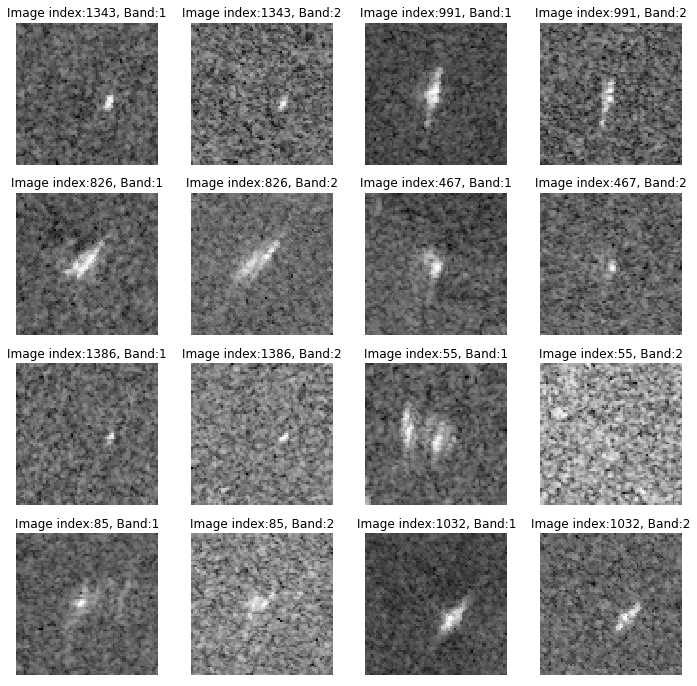

In [5]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [6]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
            if self.test is False:
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=1).copy()
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=2).copy()
                rotate = np.random.randint(4, size=1)
                if rotate:
                    img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [7]:
# train_index=list(range(1300))
# val_index= list(range(1300,1604))
train_index=list(range(304,1604)) 
val_index= list(range(304))
train_X[train_index].shape

train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 16, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

In [8]:
torch.cuda.is_available()
torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
train_X[1]
use_cuda

True

In [21]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        scheduler.step()
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_acc= acc
                e_s = 0
                torch.save(net.state_dict(), 'resnet101.pth')
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if i %100 ==0:
            torch.save(net.state_dict(), 'resnet101-00epoch.pth')
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

In [11]:
resnet101 = resnet.resnet101(num_classes=2)
net= resnet101

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov= True)
scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=250)


This is epoch:1
[=================== 82/82 ==================>]  Step: 229ms | Tot: 38s974ms | Loss: 4.111 | Acc: 61.615% (801/1300)
[=================== 5/5 ============>........]  Step: 355ms | Tot: 1s676ms | Loss: 0.820 | Acc: 50.000% (152/304)

This is epoch:2
[=================== 82/82 ==================>]  Step: 181ms | Tot: 38s986ms | Loss: 0.895 | Acc: 61.923% (805/1300)
[=================== 5/5 ============>........]  Step: 352ms | Tot: 1s679ms | Loss: 0.559 | Acc: 69.737% (212/304)

This is epoch:3
[=================== 82/82 ==================>]  Step: 182ms | Tot: 39s | Loss: 0.744 | Acc: 65.385% (850/1300)1296)
[=================== 5/5 ============>........]  Step: 351ms | Tot: 1s678ms | Loss: 0.567 | Acc: 69.408% (211/304)

This is epoch:4
[=================== 82/82 ==================>]  Step: 180ms | Tot: 39s4ms | Loss: 0.688 | Acc: 66.538% (865/1300)6)
[=================== 5/5 ============>........]  Step: 350ms | Tot: 1s677ms | Loss: 0.543 | Acc: 70.724% (215/304)

Thi

[=================== 5/5 ============>........]  Step: 356ms | Tot: 1s688ms | Loss: 0.311 | Acc: 83.882% (255/304)

This is epoch:34
[=================== 82/82 ==================>]  Step: 180ms | Tot: 39s82ms | Loss: 0.347 | Acc: 84.077% (1093/1300))
[=================== 5/5 ============>........]  Step: 355ms | Tot: 1s688ms | Loss: 0.259 | Acc: 88.816% (270/304)

This is epoch:35
[=================== 82/82 ==================>]  Step: 179ms | Tot: 39s84ms | Loss: 0.351 | Acc: 84.000% (1092/1300))
[=================== 5/5 ============>........]  Step: 351ms | Tot: 1s692ms | Loss: 0.287 | Acc: 86.513% (263/304)

This is epoch:36
[=================== 82/82 ==================>]  Step: 180ms | Tot: 39s34ms | Loss: 0.365 | Acc: 85.385% (1110/1300))
[=================== 5/5 ============>........]  Step: 351ms | Tot: 1s685ms | Loss: 0.249 | Acc: 89.803% (273/304)

This is epoch:37
[=================== 82/82 ==================>]  Step: 178ms | Tot: 38s992ms | Loss: 0.310 | Acc: 85.538% (1112/13

[=================== 82/82 ==================>]  Step: 180ms | Tot: 39s23ms | Loss: 0.275 | Acc: 88.615% (1152/1300))
[=================== 5/5 ============>........]  Step: 355ms | Tot: 1s690ms | Loss: 0.313 | Acc: 86.513% (263/304)

This is epoch:67
[=================== 82/82 ==================>]  Step: 181ms | Tot: 39s72ms | Loss: 0.318 | Acc: 86.231% (1121/1300))
[=================== 5/5 ============>........]  Step: 364ms | Tot: 1s688ms | Loss: 0.288 | Acc: 87.500% (266/304)

This is epoch:68
[=================== 82/82 ==================>]  Step: 180ms | Tot: 39s52ms | Loss: 0.277 | Acc: 88.231% (1147/1300))
[=================== 5/5 ============>........]  Step: 356ms | Tot: 1s693ms | Loss: 0.338 | Acc: 85.855% (261/304)

This is epoch:69
[=================== 82/82 ==================>]  Step: 179ms | Tot: 39s87ms | Loss: 0.306 | Acc: 86.231% (1121/1300))
[=================== 5/5 ============>........]  Step: 356ms | Tot: 1s702ms | Loss: 0.219 | Acc: 90.789% (276/304)

This is epoch

[=================== 5/5 ============>........]  Step: 358ms | Tot: 1s686ms | Loss: 0.209 | Acc: 91.776% (279/304)

This is epoch:99
[=================== 82/82 ==================>]  Step: 179ms | Tot: 39s28ms | Loss: 0.243 | Acc: 89.385% (1162/1300))
[=================== 5/5 ============>........]  Step: 353ms | Tot: 1s691ms | Loss: 0.224 | Acc: 90.461% (275/304)

This is epoch:100
[=================== 82/82 ==================>]  Step: 181ms | Tot: 39s2ms | Loss: 0.282 | Acc: 89.923% (1169/1300)6)
[=================== 5/5 ============>........]  Step: 355ms | Tot: 1s687ms | Loss: 0.226 | Acc: 91.118% (277/304)

This is epoch:101


Process Process-601:
Process Process-602:
Process Process-603:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/py

KeyboardInterrupt: 

In [22]:
##For continue training
resnet101 = resnet.resnet101(num_classes=2)
net= resnet101
net.load_state_dict(torch.load('save_resnet101.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0005, nesterov= True)
scheduler = MultiStepLR(optimizer, [30,50], gamma=0.5)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=250)


This is epoch:1
[=================== 82/82 ==================>]  Step: 180ms | Tot: 38s995ms | Loss: 0.167 | Acc: 93.231% (1212/1300)


RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:66

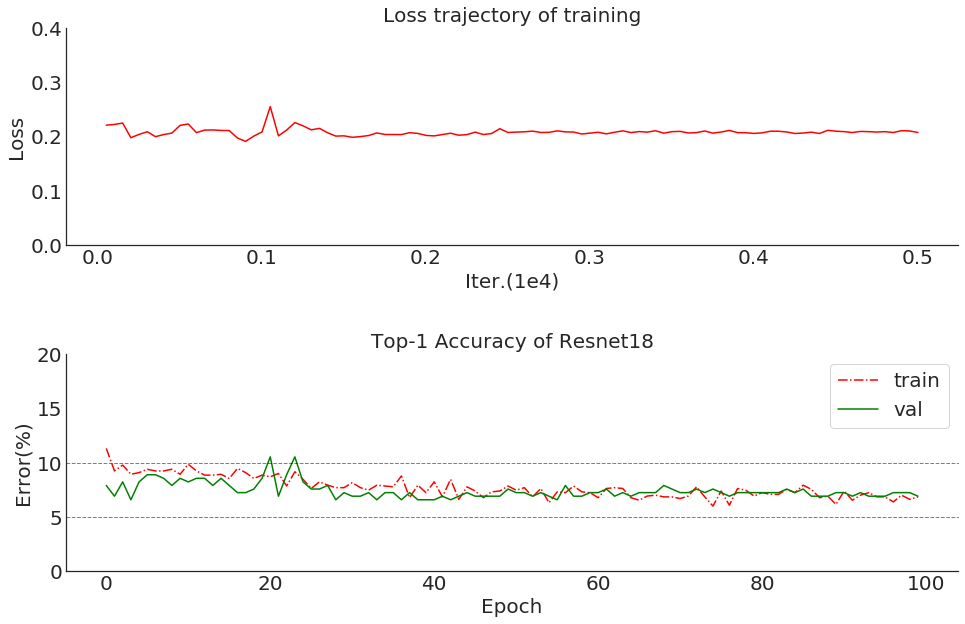

In [15]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

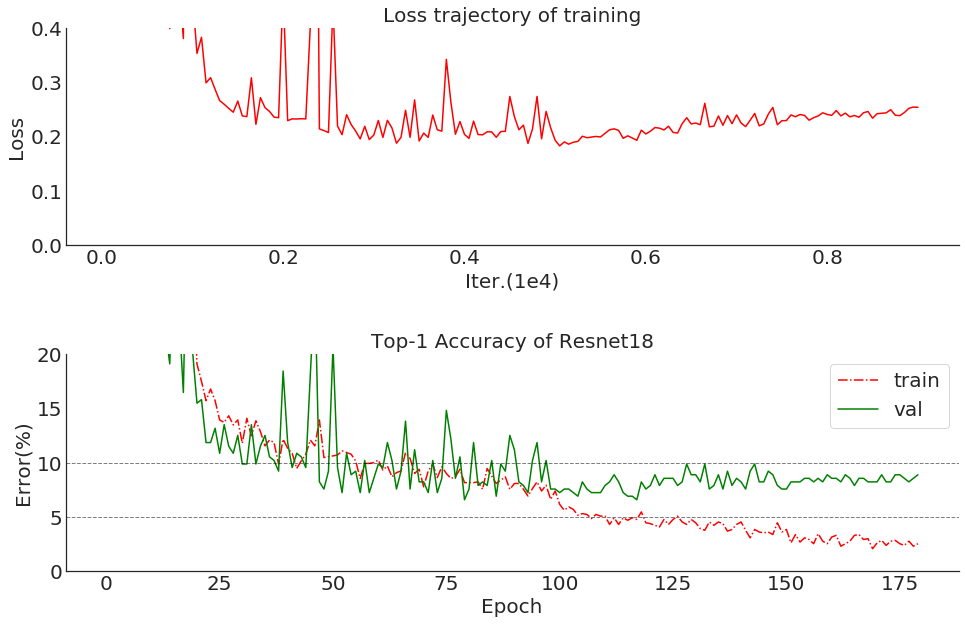

In [28]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [19]:
#Bayesian optimization

from bayes_opt import BayesianOptimization

opt_hist=[]
def resnet_evaluate(lr,wd):
    global net,criterion, optimizer,scheduler
    
    net = resnet.resnet18(num_classes=2)

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd, nesterov= True)
    scheduler = MultiStepLR(optimizer, [30,60,90], gamma=0.1)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    result = train(epoch=120,early_stopping=25)
    opt_hist.append(result)
    return result[0]

resnetOB = BayesianOptimization(resnet_evaluate, {'lr': (0.0001, 0.1),
                                                   'wd':(0.0001, 0.1)
                                                 })

resnetOB.explore({
'lr': (0.1, 0.01,0.001,0.1, 0.01,0.001),
'wd':(0.0001, 0.0001,0.0001,0.001,0.002,0.003)
})



resnetOB.maximize(init_points=3, n_iter=10,acq='ei', xi=0.05)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |        lr |        wd | 

This is epoch:1
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s44ms | Loss: 3.181 | Acc: 57.462% (747/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 45.076 | Acc: 35.526% (108/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s15ms | Loss: 0.792 | Acc: 61.154% (795/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.824 | Acc: 46.711% (142/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s27ms | Loss: 0.662 | Acc: 64.385% (837/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 632ms | Loss: 0.670 | Acc: 55.592% (169/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s4ms | Loss: 0.744 | Acc: 62.923% (818/1300)0)


[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.297 | Acc: 86.842% (264/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s29ms | Loss: 0.237 | Acc: 90.538% (1177/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.307 | Acc: 85.526% (260/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s26ms | Loss: 0.243 | Acc: 90.154% (1172/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.318 | Acc: 84.539% (257/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s20ms | Loss: 0.249 | Acc: 89.385% (1162/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.299 | Acc: 86.184% (262/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s33ms | Loss: 0.245 | Acc: 90.615% (1178/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.250 | Acc: 88.158% (268/304)

This is epoch:20
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s45ms | Loss: 0.184 | Acc: 93.077% (1210/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 630ms | Loss: 0.394 | Acc: 82.566% (251/304)

This is epoch:21
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.209 | Acc: 91.154% (1185/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.571 | Acc: 76.316% (232/304)

This is epoch:22
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.208 | Acc: 91.692% (1192/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.444 | Acc: 83.224% (253/304)

This is epoch:23
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s41ms | Loss: 0.191 | Acc: 92.077% (1197/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.300 | Acc: 86.184% (262/304)

This is epoch:31
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.178 | Acc: 93.462% (1215/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.346 | Acc: 84.539% (257/304)

This is epoch:32
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s41ms | Loss: 0.182 | Acc: 92.923% (1208/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.317 | Acc: 87.171% (265/304)

This is epoch:33
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.177 | Acc: 93.154% (1211/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.332 | Acc: 84.868% (258/304)

This is epoch:34
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s25ms | Loss: 0.175 | Acc: 93.462% (1215/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.258 | Acc: 90.461% (275/304)

This is epoch:42
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s47ms | Loss: 0.213 | Acc: 91.077% (1184/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.246 | Acc: 91.118% (277/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s52ms | Loss: 0.209 | Acc: 91.000% (1183/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 639ms | Loss: 0.269 | Acc: 88.816% (270/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s37ms | Loss: 0.211 | Acc: 91.769% (1193/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.287 | Acc: 87.171% (265/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.200 | Acc: 92.000% (1196/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.589 | Acc: 63.816% (194/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.443 | Acc: 79.923% (1039/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.496 | Acc: 71.053% (216/304)

This is epoch:5
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.426 | Acc: 80.462% (1046/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.473 | Acc: 74.342% (226/304)

This is epoch:6
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.389 | Acc: 83.077% (1080/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.485 | Acc: 72.697% (221/304)

This is epoch:7
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.376 | Acc: 83.385% (1084/1300))
[=======

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.708 | Acc: 33.553% (102/304)

This is epoch:18
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s18ms | Loss: 0.694 | Acc: 52.385% (681/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.740 | Acc: 33.553% (102/304)

This is epoch:19
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s12ms | Loss: 0.698 | Acc: 48.846% (635/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 633ms | Loss: 0.683 | Acc: 66.447% (202/304)

This is epoch:20
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s11ms | Loss: 0.695 | Acc: 50.231% (653/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.687 | Acc: 66.447% (202/304)

This is epoch:21
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s26ms | Loss: 0.696 | Acc: 51.308% (667/1300))
[=======

[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s989ms | Loss: 0.397 | Acc: 83.615% (1087/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 639ms | Loss: 0.783 | Acc: 56.908% (173/304)

This is epoch:51
[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s989ms | Loss: 0.388 | Acc: 82.923% (1078/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 636ms | Loss: 0.495 | Acc: 77.303% (235/304)

This is epoch:52
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s9ms | Loss: 0.409 | Acc: 82.308% (1070/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.507 | Acc: 75.658% (230/304)

This is epoch:53
[=================== 41/41 =================>.]  Step: 429ms | Tot: 14s987ms | Loss: 0.383 | Acc: 84.385% (1097/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.511 | Acc: 74.013% (225/304)

This is epoch:54
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.264 | Acc: 90.077% (1171/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.335 | Acc: 85.526% (260/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.279 | Acc: 89.385% (1162/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.279 | Acc: 89.803% (273/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.268 | Acc: 89.923% (1169/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.369 | Acc: 83.882% (255/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s53ms | Loss: 0.264 | Acc: 90.385% (1175/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.515 | Acc: 75.987% (231/304)

This is epoch:46
[===

[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.559 | Acc: 66.447% (202/304)

This is epoch:30
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s24ms | Loss: 0.439 | Acc: 80.692% (1049/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.826 | Acc: 51.316% (156/304)

This is epoch:31
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s16ms | Loss: 0.441 | Acc: 80.077% (1041/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 633ms | Loss: 0.592 | Acc: 66.776% (203/304)

This is epoch:32
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s10ms | Loss: 0.399 | Acc: 83.308% (1083/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.469 | Acc: 74.671% (227/304)

This is epoch:33
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s27ms | Loss: 0.370 | Acc: 84.615% (1100/1300))
[===

[=================== 5/5 ============>........]  Step: 145ms | Tot: 631ms | Loss: 0.261 | Acc: 89.803% (273/304)

This is epoch:95
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s13ms | Loss: 0.198 | Acc: 92.308% (1200/1300))
[=================== 5/5 ============>........]  Step: 148ms | Tot: 641ms | Loss: 0.270 | Acc: 89.803% (273/304)

This is epoch:96
[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s997ms | Loss: 0.189 | Acc: 92.923% (1208/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.292 | Acc: 88.487% (269/304)

This is epoch:97
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s12ms | Loss: 0.205 | Acc: 92.462% (1202/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.283 | Acc: 88.487% (269/304)

This is epoch:98
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s11ms | Loss: 0.203 | Acc: 92.000% (1196/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 632ms | Loss: 0.715 | Acc: 46.382% (141/304)

This is epoch:5
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s37ms | Loss: 0.541 | Acc: 71.615% (931/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 630ms | Loss: 0.784 | Acc: 54.276% (165/304)

This is epoch:6
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s27ms | Loss: 0.524 | Acc: 73.385% (954/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.737 | Acc: 44.079% (134/304)

This is epoch:7
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s32ms | Loss: 0.471 | Acc: 77.769% (1011/1300)
[=================== 5/5 ============>........]  Step: 147ms | Tot: 638ms | Loss: 0.843 | Acc: 40.461% (123/304)

This is epoch:8
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.462 | Acc: 79.000% (1027/1300))
[==========

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.287 | Acc: 87.500% (266/304)

This is epoch:70
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s41ms | Loss: 0.175 | Acc: 93.154% (1211/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.284 | Acc: 87.829% (267/304)

This is epoch:71
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.184 | Acc: 92.692% (1205/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.290 | Acc: 87.500% (266/304)
   12 | 19m43s |   89.80263 |    0.0992 |    0.0027 | 

This is epoch:1
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s29ms | Loss: 1.412 | Acc: 64.846% (843/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.848 | Acc: 47.368% (144/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.292 | Acc: 88.487% (269/304)

This is epoch:64
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s55ms | Loss: 0.176 | Acc: 93.308% (1213/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.287 | Acc: 86.842% (264/304)

This is epoch:65
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s34ms | Loss: 0.171 | Acc: 93.846% (1220/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 631ms | Loss: 0.272 | Acc: 88.158% (268/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s18ms | Loss: 0.160 | Acc: 93.692% (1218/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.271 | Acc: 88.158% (268/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s16ms | Loss: 0.169 | Acc: 93.231% (1212/1300))
[===

[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s10ms | Loss: 0.336 | Acc: 83.846% (1090/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.675 | Acc: 69.408% (211/304)

This is epoch:48
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s4ms | Loss: 0.329 | Acc: 84.154% (1094/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.321 | Acc: 86.842% (264/304)

This is epoch:49
[=================== 41/41 =================>.]  Step: 428ms | Tot: 14s998ms | Loss: 0.338 | Acc: 84.308% (1096/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.352 | Acc: 84.868% (258/304)

This is epoch:50
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s10ms | Loss: 0.301 | Acc: 87.231% (1134/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.321 | Acc: 85.197% (259/304)

This is epoch:51
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s38ms | Loss: 0.219 | Acc: 90.846% (1181/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.668 | Acc: 68.421% (208/304)

This is epoch:22
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.221 | Acc: 91.538% (1190/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.249 | Acc: 91.118% (277/304)

This is epoch:23
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.193 | Acc: 92.769% (1206/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.301 | Acc: 86.513% (263/304)

This is epoch:24
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s32ms | Loss: 0.225 | Acc: 91.154% (1185/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 636ms | Loss: 0.363 | Acc: 85.855% (261/304)

This is epoch:25
[===

[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.072 | Acc: 97.846% (1272/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.345 | Acc: 86.842% (264/304)

This is epoch:40
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s35ms | Loss: 0.092 | Acc: 96.308% (1252/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.359 | Acc: 86.842% (264/304)

This is epoch:41
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s40ms | Loss: 0.079 | Acc: 97.000% (1261/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.309 | Acc: 89.145% (271/304)

This is epoch:42
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.074 | Acc: 97.615% (1269/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.363 | Acc: 88.158% (268/304)

This is epoch:43
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.179 | Acc: 91.923% (1195/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.271 | Acc: 90.461% (275/304)

This is epoch:27
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s58ms | Loss: 0.186 | Acc: 92.000% (1196/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.416 | Acc: 84.868% (258/304)

This is epoch:28
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s48ms | Loss: 0.178 | Acc: 93.385% (1214/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 638ms | Loss: 0.374 | Acc: 84.539% (257/304)

This is epoch:29
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s63ms | Loss: 0.196 | Acc: 91.077% (1184/1300))
[=================== 5/5 ============>........]  Step: 146ms | Tot: 638ms | Loss: 0.718 | Acc: 73.355% (223/304)

This is epoch:30
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s28ms | Loss: 0.065 | Acc: 97.615% (1269/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.346 | Acc: 86.842% (264/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s35ms | Loss: 0.064 | Acc: 98.000% (1274/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.354 | Acc: 86.842% (264/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.086 | Acc: 97.462% (1267/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.334 | Acc: 88.487% (269/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s48ms | Loss: 0.063 | Acc: 97.846% (1272/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.384 | Acc: 85.855% (261/304)

This is epoch:46
[===

In [20]:
#30,60, 90 learning rate decay
#
resnetOB.res

{'all': {'params': [{'lr': 0.099969837126105854, 'wd': 0.0048768157841404631},
   {'lr': 0.005636454096473553, 'wd': 0.0012221947368002359},
   {'lr': 0.099246510214096528, 'wd': 0.0027344024076647543},
   {'lr': 0.099959725736288932, 'wd': 0.0024664062526430623},
   {'lr': 0.099422206390654952, 'wd': 0.0071210893402104142},
   {'lr': 0.0026487236284499088, 'wd': 0.0015270389790467936},
   {'lr': 0.0082483652834426258, 'wd': 0.0012592003869237804},
   {'lr': 0.0048465324038598672, 'wd': 0.0012104365001951837},
   {'lr': 0.0064880244084614732, 'wd': 0.0012612161415386236},
   {'lr': 0.0090556414439709517, 'wd': 0.0010343458814944075}],
  'values': [90.78947368421052,
   91.44736842105263,
   89.80263157894737,
   90.131578947368425,
   89.473684210526315,
   91.118421052631575,
   90.78947368421052,
   90.78947368421052,
   88.486842105263165,
   90.78947368421052]},
 'max': {'max_params': {'lr': 0.005636454096473553,
   'wd': 0.0012221947368002359},
  'max_val': 91.44736842105263}}

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [17]:
net = resnet.resnet101(num_classes=2)
net.load_state_dict(torch.load('save_resnet101.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[=================== 132/132 ================>]  Step: 328ms | Tot: 58s959ms


In [18]:
np.concatenate(prob).shape

(8424,)

In [19]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = np.concatenate(prob)
sub.shape
sub.to_csv('submission2.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [11]:
#try dropout 0.5 on the last fc
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov= True)
scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=250)


This is epoch:1
[=================== 41/41 =================>.]  Step: 460ms | Tot: 16s242ms | Loss: 4.618 | Acc: 56.231% (731/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 770ms | Loss: 421.466 | Acc: 50.658% (154/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 464ms | Tot: 16s191ms | Loss: 2.397 | Acc: 59.308% (771/1300)
[=================== 5/5 ============>........]  Step: 174ms | Tot: 767ms | Loss: 1032.273 | Acc: 49.342% (150/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s228ms | Loss: 1.995 | Acc: 58.154% (756/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 766ms | Loss: 522.733 | Acc: 59.539% (181/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 469ms | Tot: 16s205ms | Loss: 5.970 | Acc: 52.615% (684/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 9.002 | Acc: 50.000% (152/304)

This

[=================== 5/5 ============>........]  Step: 173ms | Tot: 769ms | Loss: 1.166 | Acc: 54.605% (166/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s185ms | Loss: 0.602 | Acc: 65.538% (852/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 837ms | Loss: 0.596 | Acc: 69.079% (210/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s185ms | Loss: 0.594 | Acc: 64.769% (842/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 772ms | Loss: 0.633 | Acc: 63.487% (193/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s184ms | Loss: 0.610 | Acc: 63.308% (823/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 769ms | Loss: 0.650 | Acc: 68.421% (208/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 466ms | Tot: 16s189ms | Loss: 0.606 | Acc: 65.077% (846/1300)
[=======

[=================== 5/5 ============>........]  Step: 172ms | Tot: 775ms | Loss: 0.245 | Acc: 89.474% (272/304)  Step: 200ms | Tot: 400ms | Loss: 0.246 | Acc: 88.021% (169/192)

This is epoch:129
[=================== 41/41 =================>.]  Step: 464ms | Tot: 16s203ms | Loss: 0.266 | Acc: 87.154% (1133/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.238 | Acc: 91.447% (278/304)  Step: 200ms | Tot: 596ms | Loss: 0.224 | Acc: 91.797% (235/256)

This is epoch:130
[=================== 41/41 =================>.]  Step: 462ms | Tot: 16s211ms | Loss: 0.272 | Acc: 87.923% (1143/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 769ms | Loss: 0.230 | Acc: 90.461% (275/304)

This is epoch:131
[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s205ms | Loss: 0.252 | Acc: 88.000% (1144/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 775ms | Loss: 0.231 | Acc: 90.789% (276/304)

This i

[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s195ms | Loss: 0.239 | Acc: 89.385% (1162/1300)
[=================== 5/5 ============>........]  Step: 171ms | Tot: 769ms | Loss: 0.215 | Acc: 91.776% (279/304)

This is epoch:193
[=================== 41/41 =================>.]  Step: 462ms | Tot: 16s206ms | Loss: 0.239 | Acc: 89.846% (1168/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.214 | Acc: 92.434% (281/304)

This is epoch:194
[=================== 41/41 =================>.]  Step: 460ms | Tot: 16s207ms | Loss: 0.230 | Acc: 90.231% (1173/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.215 | Acc: 91.447% (278/304)

This is epoch:195
[=================== 41/41 =================>.]  Step: 458ms | Tot: 16s180ms | Loss: 0.230 | Acc: 90.385% (1175/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.216 | Acc: 91.447% (278/304)

This is epoch:196


(93.42105263157895, 249)

In [7]:
def train(epoch,early_stopping = None):
    global train_data, lr#,out,y,predicted
    best_acc =0
    val_loss =0
    acc= 0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step(acc)
        scheduler.step()
        if lr != optimizer.param_groups[0]['lr']:
            print('We change learning rate from %f to %f '%(lr, optimizer.param_groups[0]['lr']))
            lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_acc= acc
                e_s = 0
                torch.save(net.state_dict(), 'resnet34_acc%d.pth'%(k))
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total


spliter = KFold(n_splits=5)
#Try different transformation

result_hist=[]
for k,(train_index, val_index) in enumerate(spliter.split(train_X)):
    train_X[train_index].shape

    train_mean, train_std = transform_compute(train_X[train_index])
    train_transform = T.Compose([
        T.Normalize(train_mean, train_std)
    ])

    train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
    val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

    train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                              shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

    resnet34 = resnet.resnet34(num_classes=2)
    net= resnet34

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here   
    #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov= True)
    scheduler = MultiStepLR(optimizer, [100,130,150], gamma=0.1)

    #
    #scheduler = ReduceLROnPlateau(optimizer, 'max', patience =18)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
    #     cudnn.benchmark = True   

    result = train(epoch=180)
    result_hist.append(result)


This is epoch:1
[=================== 41/41 =================>.]  Step: 191ms | Tot: 15s812ms | Loss: 2.645 | Acc: 53.936% (692/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 800ms | Loss: 0.598 | Acc: 63.551% (204/321))

This is epoch:2
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s833ms | Loss: 0.654 | Acc: 59.938% (769/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 798ms | Loss: 0.594 | Acc: 67.601% (217/321))

This is epoch:3
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s822ms | Loss: 0.682 | Acc: 60.717% (779/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 808ms | Loss: 12.294 | Acc: 51.402% (165/321))

This is epoch:4
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s855ms | Loss: 0.984 | Acc: 57.833% (742/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 803ms | Loss: 0.696 | Acc: 52.336% (168/321)) Step: 199ms

[=================== 6/6 =============>.......]  Step: 15ms | Tot: 809ms | Loss: 0.285 | Acc: 85.670% (275/321))

This is epoch:64
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s896ms | Loss: 0.286 | Acc: 86.282% (1107/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 805ms | Loss: 0.288 | Acc: 85.358% (274/321))

This is epoch:65
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s911ms | Loss: 0.306 | Acc: 86.360% (1108/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 810ms | Loss: 0.330 | Acc: 85.358% (274/321))

This is epoch:66
[=================== 41/41 =================>.]  Step: 189ms | Tot: 15s917ms | Loss: 0.339 | Acc: 84.645% (1086/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 810ms | Loss: 0.361 | Acc: 80.685% (259/321))

This is epoch:67
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s921ms | Loss: 0.305 | Acc: 84.801% (1088/1283)
[===

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s908ms | Loss: 0.196 | Acc: 91.660% (1176/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 808ms | Loss: 0.222 | Acc: 91.589% (294/321))

This is epoch:127
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s913ms | Loss: 0.205 | Acc: 92.206% (1183/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 814ms | Loss: 0.202 | Acc: 91.900% (295/321))

This is epoch:128
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s915ms | Loss: 0.200 | Acc: 92.362% (1185/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 803ms | Loss: 0.222 | Acc: 90.654% (291/321))  Step: 201ms | Tot: 589ms | Loss: 0.213 | Acc: 90.625% (232/256)

This is epoch:129
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s902ms | Loss: 0.203 | Acc: 92.128% (1182/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 

[=================== 6/6 =============>.......]  Step: 14ms | Tot: 811ms | Loss: 1.685 | Acc: 63.240% (203/321))

This is epoch:8
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s904ms | Loss: 0.703 | Acc: 59.938% (769/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 806ms | Loss: 0.602 | Acc: 48.287% (155/321))

This is epoch:9
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s907ms | Loss: 0.622 | Acc: 59.782% (767/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 812ms | Loss: 0.548 | Acc: 70.093% (225/321))  Step: 199ms | Tot: 795ms | Loss: 0.547 | Acc: 70.312% (225/320)

This is epoch:10
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s890ms | Loss: 0.641 | Acc: 63.523% (815/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 814ms | Loss: 0.562 | Acc: 70.093% (225/321))

This is epoch:11
[=================== 41/41 =================>.]  Step: 189ms |

[=================== 6/6 =============>.......]  Step: 16ms | Tot: 815ms | Loss: 0.292 | Acc: 87.539% (281/321))

This is epoch:71
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s908ms | Loss: 0.315 | Acc: 86.360% (1108/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 809ms | Loss: 0.281 | Acc: 88.474% (284/321))

This is epoch:72
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s933ms | Loss: 0.271 | Acc: 88.153% (1131/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 806ms | Loss: 0.251 | Acc: 88.474% (284/321))

This is epoch:73
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s918ms | Loss: 0.274 | Acc: 88.387% (1134/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 811ms | Loss: 0.273 | Acc: 87.227% (280/321))

This is epoch:74
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s908ms | Loss: 0.268 | Acc: 88.620% (1137/1283)
[===

[=================== 6/6 =============>.......]  Step: 16ms | Tot: 814ms | Loss: 0.243 | Acc: 87.850% (282/321))  Step: 199ms | Tot: 798ms | Loss: 0.242 | Acc: 87.812% (281/320)

This is epoch:132
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s927ms | Loss: 0.222 | Acc: 90.959% (1167/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 805ms | Loss: 0.245 | Acc: 88.474% (284/321))

This is epoch:133
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s921ms | Loss: 0.205 | Acc: 91.348% (1172/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 816ms | Loss: 0.237 | Acc: 89.408% (287/321))  Step: 200ms | Tot: 800ms | Loss: 0.235 | Acc: 89.375% (286/320)

This is epoch:134
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s926ms | Loss: 0.208 | Acc: 91.582% (1175/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 814ms | Loss: 0.224 | Acc: 89.408% (287/321))

This i

[=================== 41/41 =================>.]  Step: 189ms | Tot: 15s926ms | Loss: 0.204 | Acc: 92.050% (1181/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 813ms | Loss: 0.225 | Acc: 90.343% (290/321))

This is epoch:164
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s921ms | Loss: 0.211 | Acc: 91.894% (1179/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 804ms | Loss: 0.237 | Acc: 89.408% (287/321))  Step: 200ms | Tot: 590ms | Loss: 0.250 | Acc: 88.672% (227/256)

This is epoch:165
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s914ms | Loss: 0.213 | Acc: 91.270% (1171/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 812ms | Loss: 0.237 | Acc: 89.097% (286/321))

This is epoch:166
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s898ms | Loss: 0.213 | Acc: 92.050% (1181/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s870ms | Loss: 0.539 | Acc: 73.110% (938/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 809ms | Loss: 0.750 | Acc: 71.651% (230/321))

This is epoch:47
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s850ms | Loss: 0.587 | Acc: 68.277% (876/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 803ms | Loss: 0.540 | Acc: 73.209% (235/321))

This is epoch:48
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s891ms | Loss: 0.521 | Acc: 73.500% (943/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 811ms | Loss: 0.825 | Acc: 53.894% (173/321))

This is epoch:49
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s882ms | Loss: 0.488 | Acc: 76.617% (983/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 810ms | Loss: 0.459 | Acc: 78.816% (253/321))  Step: 200ms | Tot: 394ms 

[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s879ms | Loss: 0.256 | Acc: 89.478% (1148/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 808ms | Loss: 0.295 | Acc: 87.539% (281/321))

This is epoch:109
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s866ms | Loss: 0.245 | Acc: 90.023% (1155/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 812ms | Loss: 0.298 | Acc: 87.850% (282/321))

This is epoch:110
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s884ms | Loss: 0.260 | Acc: 88.309% (1133/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 810ms | Loss: 0.279 | Acc: 86.604% (278/321))

This is epoch:111
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s882ms | Loss: 0.248 | Acc: 88.776% (1139/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 804ms | Loss: 0.293 | Acc: 87.850% (282/321))

This is epoch:112


[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s891ms | Loss: 0.226 | Acc: 90.881% (1166/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 809ms | Loss: 0.291 | Acc: 89.097% (286/321))

This is epoch:178
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s877ms | Loss: 0.218 | Acc: 90.647% (1163/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 801ms | Loss: 0.293 | Acc: 88.474% (284/321))

This is epoch:179
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s872ms | Loss: 0.223 | Acc: 91.270% (1171/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 803ms | Loss: 0.286 | Acc: 88.474% (284/321))  Step: 199ms | Tot: 589ms | Loss: 0.290 | Acc: 87.891% (225/256)

This is epoch:180
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s884ms | Loss: 0.215 | Acc: 91.348% (1172/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 

[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s836ms | Loss: 0.554 | Acc: 69.914% (897/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 802ms | Loss: 0.527 | Acc: 73.209% (235/321))

This is epoch:58
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s847ms | Loss: 0.544 | Acc: 69.992% (898/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 796ms | Loss: 0.579 | Acc: 68.536% (220/321))

This is epoch:59
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s822ms | Loss: 0.564 | Acc: 69.992% (898/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 806ms | Loss: 0.539 | Acc: 71.963% (231/321))  Step: 200ms | Tot: 591ms | Loss: 0.537 | Acc: 72.656% (186/256)

This is epoch:60
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s869ms | Loss: 0.545 | Acc: 72.175% (926/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 813ms |

[=================== 6/6 =============>.......]  Step: 14ms | Tot: 802ms | Loss: 0.259 | Acc: 89.097% (286/321))

This is epoch:121
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s852ms | Loss: 0.286 | Acc: 87.841% (1127/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 802ms | Loss: 0.287 | Acc: 86.293% (277/321))

This is epoch:122
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s877ms | Loss: 0.297 | Acc: 87.295% (1120/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 802ms | Loss: 0.254 | Acc: 90.343% (290/321))  Step: 200ms | Tot: 590ms | Loss: 0.245 | Acc: 91.016% (233/256)

This is epoch:123
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s862ms | Loss: 0.280 | Acc: 87.607% (1124/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 804ms | Loss: 0.266 | Acc: 89.097% (286/321))

This is epoch:124
[=================== 41/41 =================>.]  Step

[=================== 41/41 =================>.]  Step: 83ms | Tot: 15s771ms | Loss: 0.646 | Acc: 66.121% (849/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 793ms | Loss: 0.686 | Acc: 54.062% (173/320)

This is epoch:4
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s741ms | Loss: 0.785 | Acc: 67.212% (863/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 787ms | Loss: 2.840 | Acc: 49.375% (158/320)

This is epoch:5
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s755ms | Loss: 0.769 | Acc: 68.536% (880/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 789ms | Loss: 0.658 | Acc: 57.500% (184/320)

This is epoch:6
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s744ms | Loss: 0.576 | Acc: 68.302% (877/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 786ms | Loss: 0.631 | Acc: 60.000% (192/320)

This is epoch:7
[===========

[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s780ms | Loss: 0.309 | Acc: 85.903% (1103/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 792ms | Loss: 0.428 | Acc: 77.188% (247/320)

This is epoch:67
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s808ms | Loss: 0.292 | Acc: 87.695% (1126/1284))
[=================== 5/5 ============>........]  Step: 199ms | Tot: 787ms | Loss: 0.372 | Acc: 80.625% (258/320)

This is epoch:68
[=================== 41/41 =================>.]  Step: 83ms | Tot: 15s780ms | Loss: 0.286 | Acc: 87.461% (1123/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 796ms | Loss: 0.529 | Acc: 73.750% (236/320)  Step: 200ms | Tot: 394ms | Loss: 0.424 | Acc: 82.292% (158/192)

This is epoch:69
[=================== 41/41 =================>.]  Step: 83ms | Tot: 15s800ms | Loss: 0.344 | Acc: 82.944% (1065/1284))
[=================== 5/5 ============>........]  Step: 199ms | Tot: 79

[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s799ms | Loss: 0.185 | Acc: 92.835% (1192/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 791ms | Loss: 0.283 | Acc: 87.812% (281/320)

This is epoch:129
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s838ms | Loss: 0.185 | Acc: 92.913% (1193/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 792ms | Loss: 0.290 | Acc: 86.250% (276/320)  Step: 199ms | Tot: 393ms | Loss: 0.241 | Acc: 89.062% (171/192)

This is epoch:130
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s807ms | Loss: 0.194 | Acc: 92.523% (1188/1284))
[=================== 5/5 ============>........]  Step: 201ms | Tot: 597ms | Loss: 0.241 | Acc: 90.234% (231/256)  Step: 200ms | Tot: 797ms | Loss: 0.300 | Acc: 87.188% (279/320)

This is epoch:131
We change learning rate from 0.010000 to 0.001000 
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15

In [13]:
#result_hist

temp11 = []
for i in range(5):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load('resnet34_acc%d.pth'%i))
    net.cuda()

    test = pd.read_json(BASE_dir + 'test.json')
    test_X = raw_to_numpy(test)
    test_X.shape 
    fake_label = np.zeros(len(test_X))

    test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

    test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    temp11.append(np.concatenate(prob))

[=================== 132/132 ================>]  Step: 153ms | Tot: 26s40mss Step: 200ms | Tot: 3s414ms  Step: 200ms | Tot: 7s377ms  Step: 199ms | Tot: 8s170ms  Step: 199ms | Tot: 8s967ms  Step: 199ms | Tot: 11s161ms 68/132   Step: 199ms | Tot: 13s944ms  Step: 199ms | Tot: 17s910ms  Step: 199ms | Tot: 18s905ms  Step: 200ms | Tot: 19s502ms  Step: 199ms | Tot: 20s700ms  Step: 199ms | Tot: 21s497ms  Step: 200ms | Tot: 22s97ms  Step: 200ms | Tot: 22s895ms  Step: 200ms | Tot: 24s91ms  Step: 200ms | Tot: 25s88ms  Step: 200ms | Tot: 25s685ms
[=================== 132/132 ================>]  Step: 152ms | Tot: 26s64mss Step: 200ms | Tot: 2s211ms  Step: 199ms | Tot: 3s408ms  Step: 200ms | Tot: 5s200ms  Step: 200ms | Tot: 7s773ms  Step: 200ms | Tot: 14s152ms  Step: 200ms | Tot: 15s149ms  Step: 200ms | Tot: 16s350ms  Step: 199ms | Tot: 19s346ms  Step: 199ms | Tot: 20s728ms  Step: 199ms | Tot: 22s720ms  Step: 199ms | Tot: 23s318ms  Step: 200ms | Tot: 23s719ms  Step: 200ms | Tot: 24s514ms  Step: 200

In [20]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = result/5
sub.shape
sub.to_csv('submission4.csv',index=False)


In [18]:
result = 0
for i in temp11:
    result+=i


In [19]:
result

array([  1.90692261e-01,   3.32861006e-01,   3.52750561e-07, ...,
         1.14791021e-01,   4.95005941e+00,   1.33138565e-05], dtype=float32)